# Восстановление золота из руды

<b>Задача проекта</b> - подготовить прототип модели машинного обучения, способная предсказать коэффициент восстановления золота из золотосодержащей руды.

<b>Цель проекта</b> - получить модель с лучшим показателем метрики sMAPE.

В данном проекте используются данные с параметрами добычи и очистки.

<b>Описание данных</b>

Технологический процесс:
   - Rougher feed — исходное сырье
   - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
   - Rougher process (англ. «грубый процесс») — флотация
   - Rougher tails — отвальные хвосты
   - Float banks — флотационная установка
   - Cleaner process — очистка
   - Rougher Au — черновой концентрат золота
   - Final Au — финальный концентрат золота

Параметры этапов:
   - air amount — объём воздуха
   - fluid levels — уровень жидкости
   - feed size — размер гранул сырья
   - feed rate — скорость подачи

Этапы:
   - rougher — флотация
   - primary_cleaner — первичная очистка
   - secondary_cleaner — вторичная очистка
   - final — финальные характеристики

Параметры: 
   - input — параметры сырья
   - output — параметры продукта
   - state — параметры, характеризующие текущее состояние этапа
   - calculation — расчётные характеристики

<b>План проекта:</b>
1. Подготовить данные;
   - Открыть и изучить исходные данные;
   - Проверить, что эффективность обогащения рассчитана правильно;
   - Проанализировать признаки, недоступные в тестовой выборке;
   - Провести предобработку данных.
2. Проанализировать данные
   - Оценить распределение концентрации металлов (Au, Ag, Pb) на различных этапах очистки;
   - Сравнить распределения размеров гранул сырья на обучающей и тестовой выборках;
   - Исследовать суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 
3. Построить модель
   - Написать функцию для вычисления итоговой sMAPE;
   - Обучить разные модели и оценить их качество кросс-валидацией. Выберать лучшую модель и проверить её на тестовой выборке. 

## Подготовка данных

In [1]:
#загрузим необходимые библиотеки
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import RobustScaler

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
#Загрузим датасеты

def read_df(df):
    if os.path.exists('/datasets/'+df):
        df_raw = pd.read_csv('/datasets/'+df)
        print('platform')
    else:
        df_raw = pd.read_csv(df)
        print('remote')
    return df_raw
    
df_train_raw = read_df('gold_recovery_train_new.csv')
df_test_raw = read_df('gold_recovery_test_new.csv')
df_full_raw = read_df('gold_recovery_full_new.csv')

platform
platform
platform


### Анализ исходных данных

In [3]:
#создадим функцию для упрощенного вывода отчета по данным
def mini_report(df):
    print('Head')
    display(df.head())
    print('')
    print('Describe')
    display(df.describe())
    print('')
    print('Info')
    df.info()
    display(pd.DataFrame(df.isna().mean()*100)
            .style.set_precision(2)
            .background_gradient('coolwarm'))
    print('Всего пропущенных значений %', 
          pd.DataFrame(df.isna().mean()*100).sum())

In [4]:
mini_report(df_full_raw)

Head


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.


Describe


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19439.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19339.000000,19428.000000,19294.000000,19340.000000,19439.000000,19405.000000,19431.000000,19395.000000,18986.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19439.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438


Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  fl

,0
date,0.00
final.output.concentrate_ag,0.01
final.output.concentrate_pb,0.01
final.output.concentrate_sol,1.09
final.output.concentrate_au,0.00
final.output.recovery,0.00
final.output.tail_ag,0.01
final.output.tail_pb,0.52
final.output.tail_sol,0.03
final.output.tail_au,0.00


Всего пропущенных значений % 0    23.051597
dtype: float64


In [5]:
mini_report(df_train_raw)

Head


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.


Describe


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148


Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  fl

,0
date,0.00
final.output.concentrate_ag,0.01
final.output.concentrate_pb,0.01
final.output.concentrate_sol,1.49
final.output.concentrate_au,0.00
final.output.recovery,0.00
final.output.tail_ag,0.00
final.output.tail_pb,0.71
final.output.tail_sol,0.04
final.output.tail_au,0.00


Всего пропущенных значений % 0    28.977313
dtype: float64


In [6]:
mini_report(df_test_raw)

Head


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50


Describe


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20


Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primar

,0
date,0.00
primary_cleaner.input.sulfate,0.08
primary_cleaner.input.depressant,0.09
primary_cleaner.input.feed_size,0.00
primary_cleaner.input.xanthate,0.08
primary_cleaner.state.floatbank8_a_air,0.00
primary_cleaner.state.floatbank8_a_level,0.00
primary_cleaner.state.floatbank8_b_air,0.00
primary_cleaner.state.floatbank8_b_level,0.00
primary_cleaner.state.floatbank8_c_air,0.00


Всего пропущенных значений % 0    1.701323
dtype: float64


### Проверка вычислений

In [7]:
T = df_train_raw['rougher.output.tail_au']
C = df_train_raw['rougher.output.concentrate_au']
F = df_train_raw['rougher.input.feed_au']

check_rougher_recovery = pd.Series(((C * (F - T)) / (F * (C - T))) * 100)

mean_absolute_error(df_train_raw['rougher.output.recovery'], check_rougher_recovery)

9.73512347450521e-15

### Проверка состава признаков

In [8]:
diff_columns = set(df_train_raw.columns) - set(df_test_raw.columns)
diff_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Из тестовой выборки удалены столбцы с результатами концентраций элементов в сырье на всех этапах обработки сырья, а также состав элементов в отвальных хвостах. Кроме того, отсутвуют признаки с эффективность обогащения. Еще в тестовой выборке отсутвуют столбцы с данными, используемыми для расчета эффективности обогащения. Эти данные неизвестны до начала процесса добычи.

### Предобработка данных

In [9]:
#скопируем датасеты, оставив исходные бех изменений
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()
df_full = df_full_raw.copy()

In [10]:
#удалим из тренировочных данных признаки, которых нет в тестовых, за исключением целевых
diff_to_drop = diff_columns - set(['final.output.recovery', 'rougher.output.recovery'])

df_train = df_train.drop(diff_to_drop, axis=1)

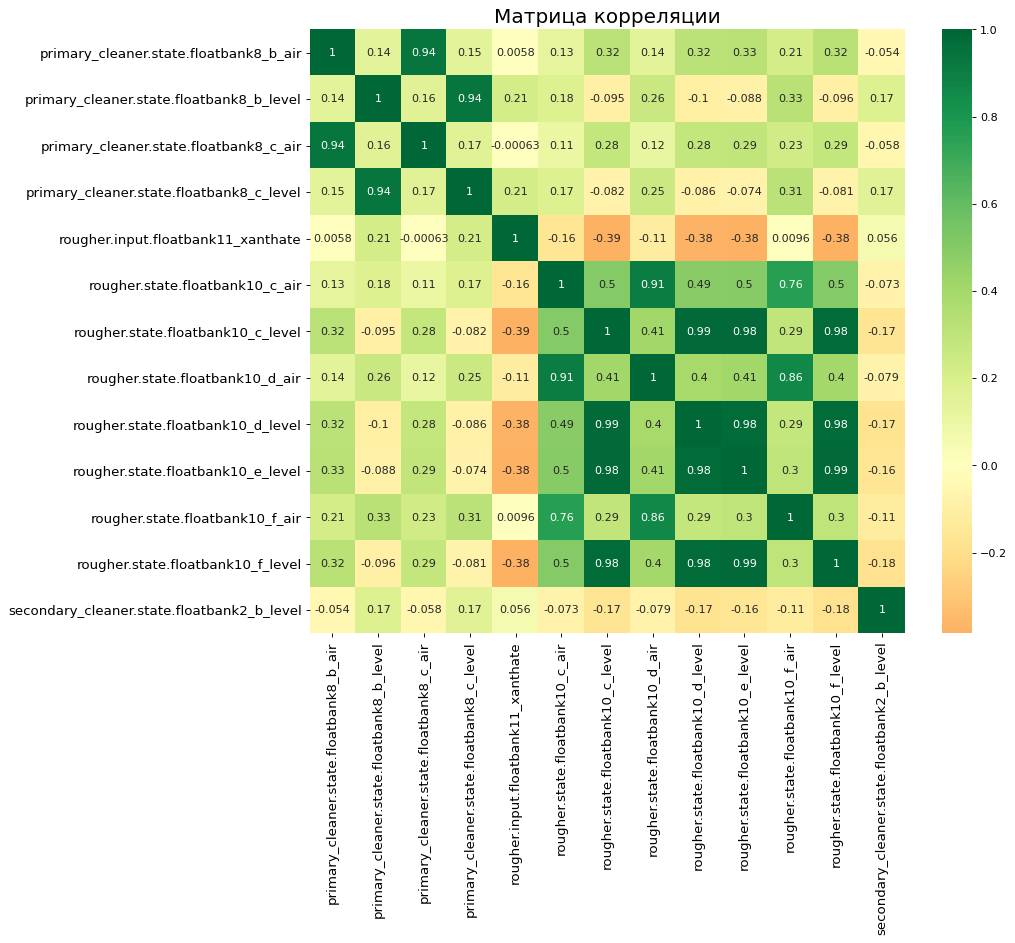

In [11]:
# вычислим корреляцию признаков и выведем только "весьма высокие" показатели корреляции по шкале Чеддока

corr_matrix = df_train.corr().abs()

# выберем верхний треугольник матрицы
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# найдем индексы признаков с корреляцией больше 0.9
high_corr = [column for column in upper.columns if any(upper[column] > 0.9)]

# отрисуем полученную матрицу
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df_train[high_corr].corr(), xticklabels=df_train[high_corr].corr().columns, 
            yticklabels=df_train[high_corr].corr().columns, cmap='RdYlGn', 
            center=0, annot=True)

plt.title('Матрица корреляции', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [12]:
df_train = df_train.drop(high_corr, axis=1)
df_test = df_test.drop(high_corr, axis=1)

In [13]:
# преобразуем столбец с датами в соответствующий тип
df_train['date'] = pd.to_datetime(
    df_train['date'], format='%Y-%m-%dT%H:%M:%S')

df_test['date'] = pd.to_datetime(
    df_test['date'], format='%Y-%m-%dT%H:%M:%S')

df_full['date'] = pd.to_datetime(
    df_full['date'], format='%Y-%m-%dT%H:%M:%S')

In [14]:
#в тестовых данных пропусков меньше 2%, их можно просто удалить
df_test.dropna(inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5243 entries, 0 to 5289
Data columns (total 40 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5243 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5243 non-null   float64       
 2   primary_cleaner.input.depressant            5243 non-null   float64       
 3   primary_cleaner.input.feed_size             5243 non-null   float64       
 4   primary_cleaner.input.xanthate              5243 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5243 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5243 non-null   float64       
 7   primary_cleaner.state.floatbank8_d_air      5243 non-null   float64       
 8   primary_cleaner.state.floatbank8_d_level    5243 non-null   float64       
 9   rougher.

В тренировочных данных пропусков более 20%. Здесь пропуски необходимо заполнить. Для этого, посмотрим подробнее на этапы обработки сырья и попробуем выявить зависимости.

In [15]:
nans = df_train.loc[:, df_train.columns[df_train.isna().any()]].isna().sum()

def fill_nans(df1, df2, list_of_nans):
    for column in list_of_nans:
        nans_index = df1[column].index[df1[column].apply(np.isnan)]
        for i in nans_index:
            if pd.isnull(df1.at[i, column]):
                df1.at[i, column] = df2.at[i-1, column]
    return df1

df_train = fill_nans(df_train, df_full, list(nans.index))

df_train.info()
print('Всего пропущенных значений %', pd.DataFrame(df_train.isna().mean()*100).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 42 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        14149 non-null  datetime64[ns]
 1   final.output.recovery                       14149 non-null  float64       
 2   primary_cleaner.input.sulfate               14149 non-null  float64       
 3   primary_cleaner.input.depressant            14145 non-null  float64       
 4   primary_cleaner.input.feed_size             14149 non-null  float64       
 5   primary_cleaner.input.xanthate              14146 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_air      14149 non-null  float64       
 7   primary_cleaner.state.floatbank8_a_level    14149 non-null  float64       
 8   primary_cleaner.state.floatbank8_d_air      14149 non-null  float64       
 9   primar

In [17]:
#когда пропущенных значений меньше 1%, можно удалить то, что не получилось заполнить
df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14007 entries, 0 to 14148
Data columns (total 42 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        14007 non-null  datetime64[ns]
 1   final.output.recovery                       14007 non-null  float64       
 2   primary_cleaner.input.sulfate               14007 non-null  float64       
 3   primary_cleaner.input.depressant            14007 non-null  float64       
 4   primary_cleaner.input.feed_size             14007 non-null  float64       
 5   primary_cleaner.input.xanthate              14007 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_air      14007 non-null  float64       
 7   primary_cleaner.state.floatbank8_a_level    14007 non-null  float64       
 8   primary_cleaner.state.floatbank8_d_air      14007 non-null  float64       
 9   primar

Данные в тренировочной и тестовой выборке обработаны. Количество признаков выравнено (в тренировочной необходимо будет еще отделить таргет), заполнены и удалены пропуски. Кроме того, из выборок удалены коррелирующие между собой признаки. Дело в том, мультиколлинеарность может стать причиной переобучаемости моделиь. 

## Анализ данных

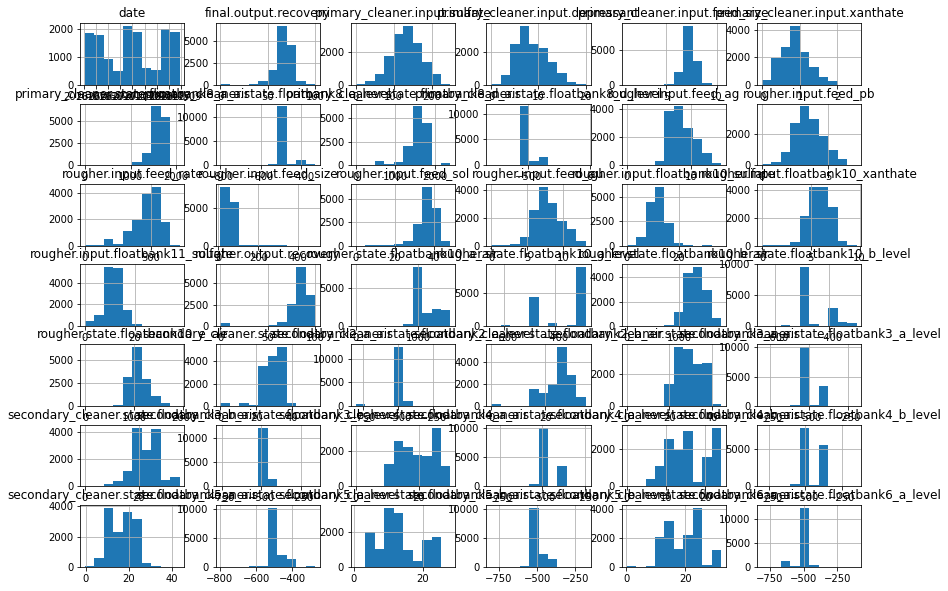

In [18]:
# посмотрим на общий характер распределения данных на тренировочной выборке для оставшихся признаков
df_train.hist(figsize=(14, 10))
None

Признаков все равно достаточно много. Но детально рассматривать каждый не имеет смысла и занимает очень много времени. Для построения модели машинного обучения будет полезно знать нормально ли распределны значения и в каких масштабах, кроме того, можно приблизительно увидеть, есть ли выбросы. Можно отметить, что данные в некоторых столбцах распределы неравномерно, так же имеются выбросы. Кроме того, можно отметить разный масштаб данных, что стоит учесть при обучении модели линейной регрессии.

In [19]:
# изучим процентное соотношение околонулевых выбросов к каждой колонке
df = df_train.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis=1)

size = []
name_column = []
for column in list(df.columns):
    Q1 =  df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    for_cut = len(df[(df[column] > (Q1-1.5*IQR))])
    sizes = ((len(df[column])-for_cut)/for_cut)*100
    if sizes > 0:
        size.append(sizes)
        name_column.append(column)

emissions = pd.DataFrame(data=size, index=name_column).style.set_precision(3).background_gradient('coolwarm')
emissions

,0
primary_cleaner.input.sulfate,0.308
primary_cleaner.input.feed_size,1.104
primary_cleaner.state.floatbank8_a_air,10.815
primary_cleaner.state.floatbank8_a_level,3.365
primary_cleaner.state.floatbank8_d_air,6.712
primary_cleaner.state.floatbank8_d_level,6.574
rougher.input.feed_ag,0.150
rougher.input.feed_pb,0.315
rougher.input.feed_rate,4.514
rougher.input.feed_size,0.107


В сумме получается внушительное количество выбросов по первому квартилю. Удалить эти значения не выйдет. Изучим аномалии по боксплотам для столбцов с выбросами.

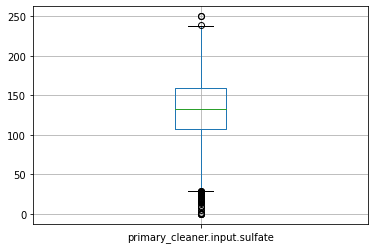

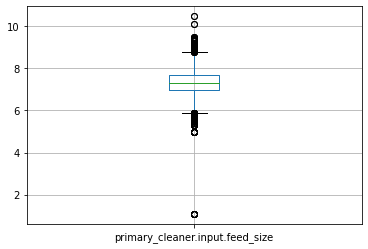

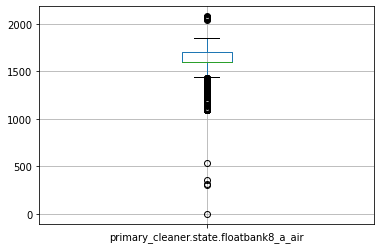

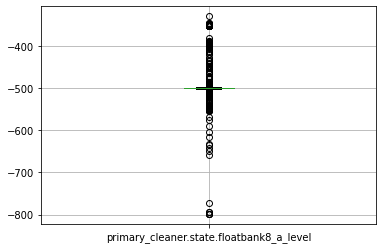

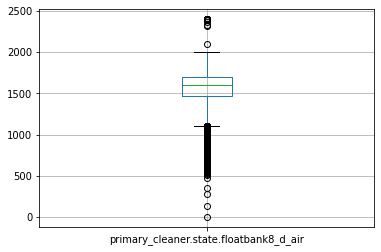

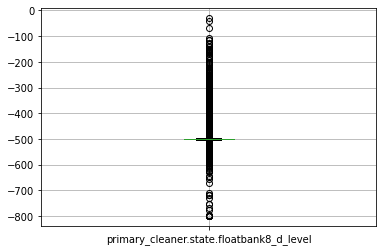

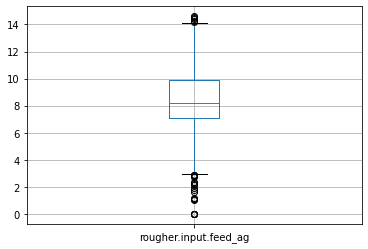

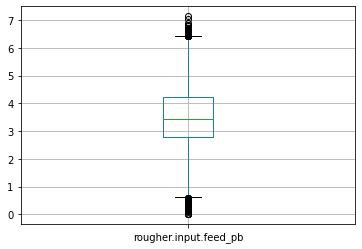

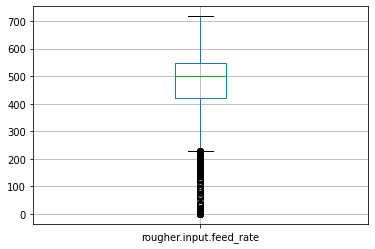

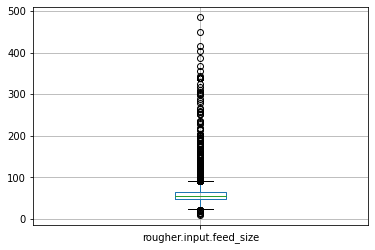

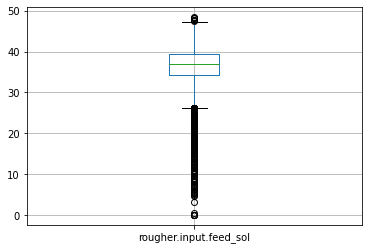

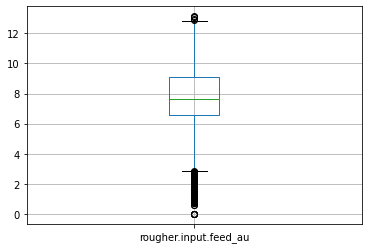

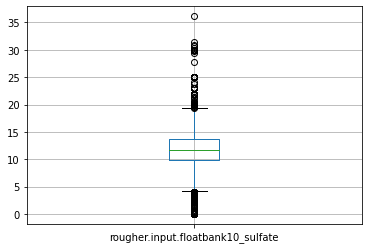

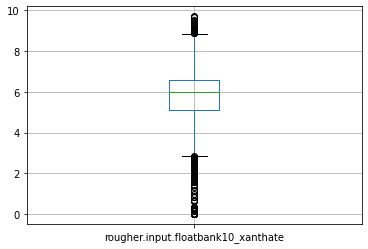

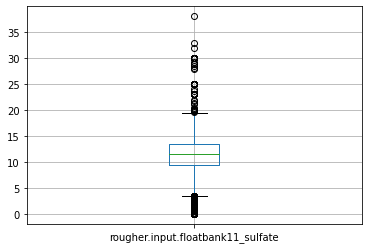

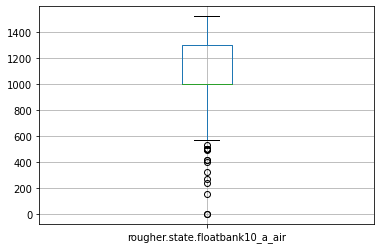

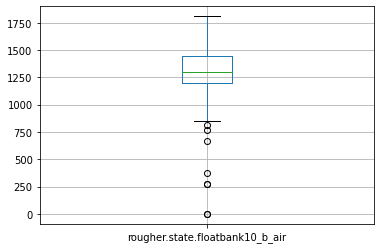

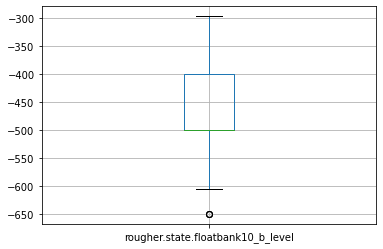

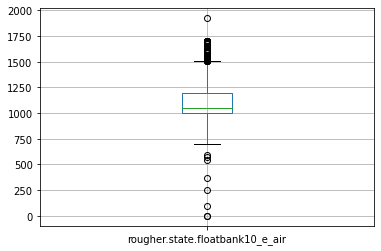

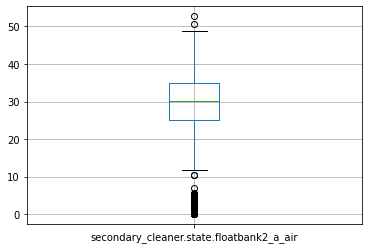

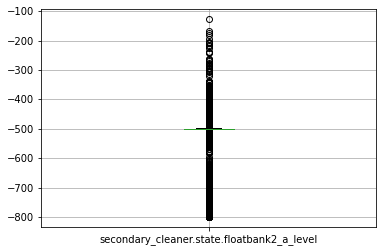

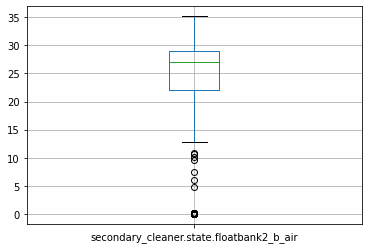

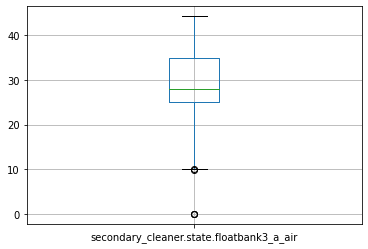

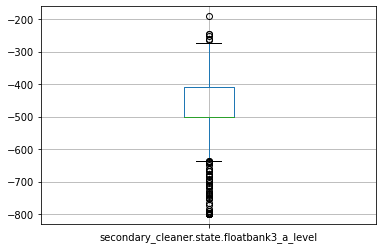

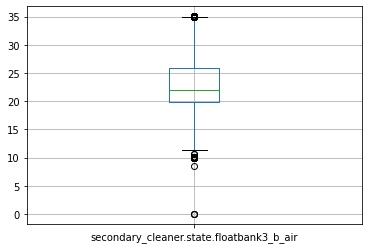

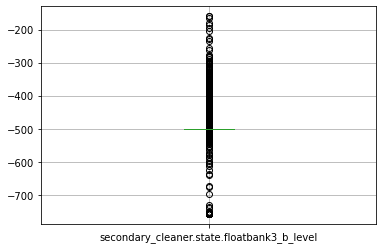

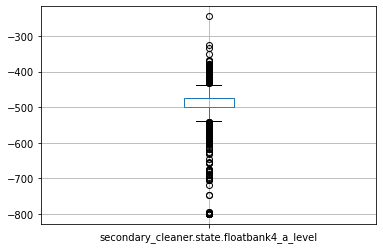

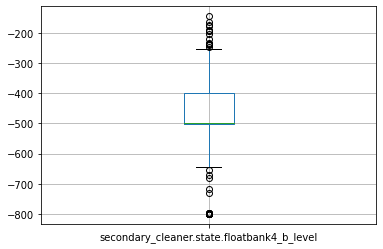

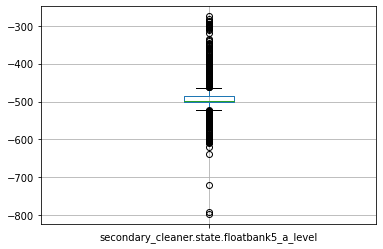

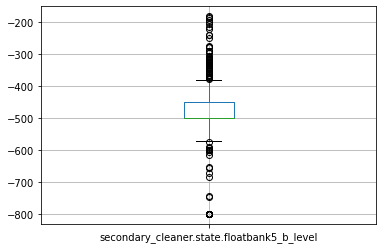

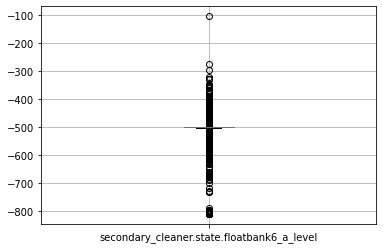

In [20]:
for columns in name_column:
    df_train.boxplot(column=columns)
    plt.show()

In [21]:
# судя по распределнию данных, в столбцах встречается какое-то количество нулевых значений
len(df_train.loc[(df_train==0).any(axis=1)]) / len(df_train) *100

2.6272577996715927

Строк с нулевыми значениями около 3% на весь датафрейм. Можно их удалить.

In [22]:
#удалим строки с нулевыми значениями и посмотрим, что получилось
to_drop_rows = df_train.loc[(df_train==0).any(axis=1)]
idexes_to_drop = list(to_drop_rows.index)

df_train = df_train.drop(index=idexes_to_drop)
df_train.describe()

,final.output.recovery,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.output.recovery,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_e_air,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,1.363900e+04,1.363900e+04,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000,13639.000000
mean,66.855251,134.192441,8.896800,7.315373,0.889273,1607.722866,-488.690715,1543.780339,-483.394351,8.576750,3.527803,475.393029,60.160305,36.342352,7.859938,11.740268,5.878446,11.351940,84.589727,1124.629573,-369.217120,1321.961243,-464.425686,1088.867388,29.677147,-501.383413,2.504023e+01,2.931504e+01,-477.969539,22.729137,-488.752016,20.078780,-478.480382,15.579012,-460.343733,16.847524,-483.817699,13.150044,-483.810697,19.615974,-506.944213
std,9.314117,39.051012,3.331358,0.611213,0.374382,128.925064,35.853954,276.400204,46.454459,1.897878,1.076252,103.308936,22.577486,4.955926,1.925229,3.214331,1.090950,3.670588,7.938342,168.786076,93.854411,182.038780,57.317079,183.196383,5.710584,58.731182,5.865930e+00,5.620082e+00,54.626828,4.958506,41.739645,5.675685,50.802080,5.245698,58.601509,5.835734,38.077131,5.773329,38.870814,5.733827,37.030692
min,0.168611,0.003112,0.007721,1.080000,0.000154,0.016993,-798.641662,0.023153,-799.788598,0.010000,0.010000,0.012786,9.659576,0.010000,0.010000,0.001164,0.001428,0.000098,2.520854,-0.041078,-650.178471,-0.653384,-650.252108,-1.936877,0.077503,-799.606441,6.778101e-18,1.511458e-07,-799.573257,0.000078,-757.801765,0.000073,-799.706757,0.000068,-799.860840,-0.372054,-797.142475,0.668043,-800.006180,0.195324,-809.392602
25%,62.765662,108.394225,6.050461,6.950000,0.608618,1591.764830,-500.287102,1453.836917,-500.455065,7.118199,2.783661,424.608772,49.004285,34.133146,6.580401,9.851514,5.194644,9.505549,80.434758,999.806093,-499.784282,1199.410064,-500.183709,997.642489,25.113071,-500.245717,2.284928e+01,2.499153e+01,-500.175161,19.948878,-500.109451,14.994811,-500.630251,11.925824,-500.152919,11.110181,-500.363114,8.999010,-500.105797,14.990249,-500.755418
50%,67.479309,133.918139,8.035887,7.290000,0.889572,1601.912128,-499.908491,1600.173086,-499.830035,8.162334,3.430663,499.674333,55.451918,37.047836,7.642549,11.763540,5.995763,11.443611,85.591280,1001.777960,-300.174729,1301.408391,-499.766996,1050.339993,30.031229,-499.956026,2.704044e+

Оставим данные в таком виде. Выбросов в интервале от третьего квартиля и выше достаточно много, а некоторые столбцы и вовсе представляют собой сплошные выбросы. Поэтому в данном случае сложно определить, какие значения стоит удалить.

### Изменение концентрации металлов на различных этапах очистки

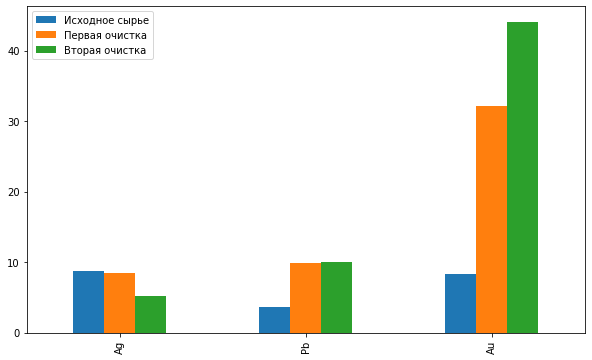

In [23]:
# посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки
rougher_col = ['rougher.input.feed_ag',
              'rougher.input.feed_pb',
              'rougher.input.feed_au']

final_col = ['final.output.concentrate_ag',
             'final.output.concentrate_pb',
             'final.output.concentrate_au']

primary_col = ['primary_cleaner.output.concentrate_ag',
               'primary_cleaner.output.concentrate_pb',
               'primary_cleaner.output.concentrate_au']

df_rougher = df_full[rougher_col]
df_firs = df_full[primary_col]
df_second = df_full[final_col]

#сравним со средним значеним для каждого региона
column = ['Ag', 'Pb', 'Au']

profit_real = (
    [df_rougher.mean().values,
     df_firs.mean().values,
     df_second.mean().values])

#добавим данные в датафрейм и выведем тадлицу
profit_data = pd.DataFrame(data=profit_real, columns=column).astype(float)
profit_data.index = ['Исходное сырье', 'Первая очистка', 'Вторая очистка']

profit_data.T.plot(kind='bar', figsize=(10, 6))
None

Концентрация металлов имеет разный характер средних значений для этапов очистки. Так концентрация серебра уменьшается по мере очистки. Концентрация золота наоборот увеличивается. Концентрация свинца увеличивается после обогащения и остается практически неизменной после первичной и вторичной очистки.

### Распределения размеров гранул сырья

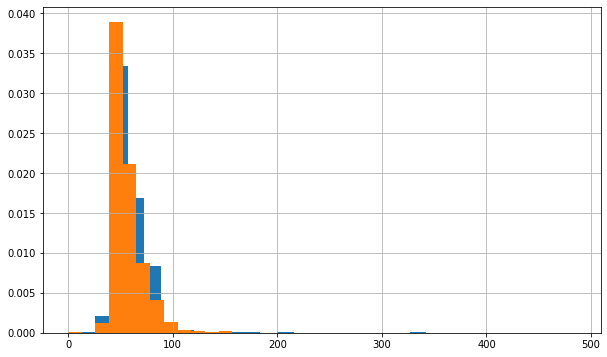

In [24]:
# посмотрим на распределения размеров гранул сырья на обучающей и тестовой выборках
df_train['rougher.input.feed_size'].hist(bins=30, density=True, figsize=(10, 6))
df_test['rougher.input.feed_size'].hist(bins=30, density=True, figsize=(10, 6))
None

Картина распределения размера гранул для тренировочной и тестовой выборки имеет схожий характер. В данном случае можно рассчитывать на адекватную оценку модели.

### Суммарная концентрация всех веществ на разных стадиях

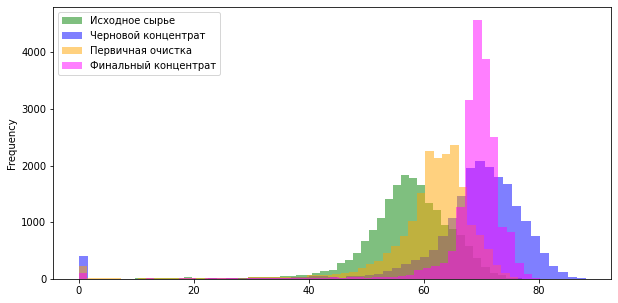

In [25]:
feed_new = ['rougher.input.feed_ag',
            'rougher.input.feed_pb',
            'rougher.input.feed_au',
            'rougher.input.feed_sol']

rougher_new = ['rougher.output.concentrate_ag',
               'rougher.output.concentrate_pb',
               'rougher.output.concentrate_au',
               'rougher.output.concentrate_sol']

final_new = ['final.output.concentrate_ag',
              'final.output.concentrate_pb',
              'final.output.concentrate_au',
              'final.output.concentrate_sol']

primary_new = ['primary_cleaner.output.concentrate_ag',
               'primary_cleaner.output.concentrate_pb',
               'primary_cleaner.output.concentrate_au',
               'primary_cleaner.output.concentrate_sol']


df_feed_all= df_full[feed_new]
df_rougher_all = df_full[rougher_new]
df_firs_all = df_full[primary_new]
df_final_all = df_full[final_new]

#сравним со средним значеним для каждого региона
df_feed_all.sum(axis=1).plot(kind='hist', label='Исходное сырье', bins=55, alpha=0.5, color='green', figsize=(10, 5))
df_rougher_all.sum(axis=1).plot(kind='hist', label='Черновой концентрат', bins=55, alpha=0.5, color='blue', figsize=(10, 5))
df_firs_all.sum(axis=1).plot(kind='hist', label='Первичная очистка', bins=55, alpha=0.5, color='orange', figsize=(10, 5))
df_final_all.sum(axis=1).plot(kind='hist', label='Финальный концентрат', bins=55, alpha=0.5, color='magenta', figsize=(10, 5))
plt.legend()
None

На данном этапе проанализироаны данные по полному датасету, а также выполнено сравнение одной из ключевых характеристик в тестовых и тренировочных данных. Концентрация золота логично увеличивается в сыре по мере очистки, а общее количество веществ растет на каждом этапе. Кроме того, замечены нулевые значения. Поскольку концентрация веществ не может быть нулевой, данные значения - аномалии, от которых следует избавиться.

В тренировочных данных, которые будут использоваться для обучения модели, все нулевые значения уже удалены.

## Модель

### Подготовка выборок

In [26]:
# Создадим выборки с признаками и целями для тренировочных и тестовых данных
X_train = df_train.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
y1_train = df_train['rougher.output.recovery'] #выборка для первого целевого признака
y2_train = df_train['final.output.recovery'] #выборка для второго целевого признака

#определим признаки для тествой выборки
X_test = df_test.drop(['date'], axis=1)

#в тестовых данных остуствуют целевые признаки. Добавим их из общей выборки
y_test = df_full.loc[df_full.index[list(X_test.index)]]
y1_test = y_test['rougher.output.recovery'] #выборка для первого целевого признака
y2_test = y_test['final.output.recovery'] #выборка для второго целевого признака


print('Тренировочная выборка')
display(X_train.shape)
display(y1_train.shape)
display(y2_train.shape)
print('Тестовые выборки')
display(X_test.shape)
display(y1_test.shape)
display(y2_test.shape)

Тренировочная выборка


(13639, 39)

(13639,)

(13639,)

Тестовые выборки


(5243, 39)

(5243,)

(5243,)

In [27]:
# далее сбросим индексы, чтобы не возникали ошибки на кросс-валидации
X_train = X_train.reset_index(drop=True)
y1_train = y1_train.reset_index(drop=True)
y2_train = y2_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y1_test = y1_test.reset_index(drop=True)
y2_test = y2_test.reset_index(drop=True)

### Масштабирование признаков

In [27]:
#выполним масштабирование признаков для модели линейной регрессии
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

#определим численные столбцы для масштабирования
numeric = X_test_scaled.columns

#определим инструмент для масштабирования и обучим и применим на тренировочных данных
scaler = RobustScaler()
X_train_scaled[numeric] = scaler.fit_transform(X_train_scaled[numeric])
X_test_scaled[numeric] = scaler.transform(X_test_scaled[numeric])

display(X_train_scaled)
display(X_test_scaled)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_e_air,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,-0.131868,0.389517,-0.054054,0.200650,-0.482600,1.087698,-0.186555,3.249430,-0.731905,-0.787399,0.192880,0.002035,-0.044894,-0.461848,0.059762,0.008413,0.098497,-0.006912,-0.519925,1.204875,0.652196,1.750510,-0.426995,2.158592,-0.514716,-0.405911,0.047336,-0.019255,1.777498,-0.599170,-0.071063,-0.353960,-0.053184,-0.739241,0.063307,-0.435993,-0.011206,-0.583323,-87.049477
1,-0.160126,0.420783,-0.054054,0.228777,-0.238313,-1.087832,-0.104645,0.455988,-0.710346,-0.800374,0.206974,0.107177,-0.242904,-0.464871,0.055630,0.006883,0.138438,-0.004978,-0.499898,1.195860,0.499419,1.724583,-0.424191,-0.050782,-0.515391,-0.405036,-0.002129,0.004852,1.476490,-0.601626,-0.147415,-0.372303,-0.019375,-0.728783,-0.021389,-0.446535,-0.013448,-0.598619,-82.066767
2,-0.195080,0.610669,-0.054054,0.205721,-0.003295,-0.097487,-0.002572,0.001315,-0.726198,-0.873503,0.245240,0.120788,-0.201951,-0.511343,0.042077,0.138727,0.119433,-0.006869,-0.499943,1.190198,0.498867,1.724355,-0.411447,0.039879,-0.515861,-0.410736,0.004467,0.315432,0.183258,-0.599352,-0.071896,-0.376937,-0.017396,-0.725868,-0.019529,-0.443301,-0.012146,-0.595589,-83.416529
3,-0.225016,0.611760,-0.054054,0.216793,-0.017989,-1.138937,0.001126,-0.112955,-0.752162,-0.957218,0.346752,0.137338,-0.034827,-0.608806,-0.035750,0.142718,0.062345,-0.006552,-0.500574,1.193083,0.492737,1.733066,-0.417858,1.176703,-0.504598,-0.405407,-0.001343,0.314889,0.061836,-0.597202,-0.029771,-0.366284,-0.017998,-0.735123,0.022711,-0.447361,-0.006870,-0.597900,-82.238715
4,-0.307736,0.721867,-0.054054,0.243355,-0.005299,1.018577,0.010086,-0.387265,-0.745912,-1.129667,0.330120,0.034925,-0.506688,-0.790320,-0.215869,0.139724,-0.121035,-0.007006,-0.498335,1.193680,0.502966,1.736120,-0.409450,-0.487826,-0.504626,-0.403521,-0.002112,0.315636,-0.067742,-0.598124,-0.003977,-0.371991,-0.016602,-0.739234,-0.090463,-0.456590,-0.008889,-0.598790,-83.473581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13634,-0.203542,-0.001296,-1.067567,0.838834,0.430511,108.651033,0.198184,50.838874,-0.734930,0.815675,0.494602,1.775764,0.060412,-0.921256,-1.071801,2.176302,-0.921217,0.659006,-0.003357,-0.605630,0.009798,-0.991957,0.512213,1.374631,0.468825,-0.201880,-0.000775,0.154422,-0.002502,0.302458,-0.037637,0.616896,-0.003477,0.004550,-0.006105,0.110667,-0.004849,0.002239,-1.015161
13635,-0.251907,-0.013636,-1.067567,0.835165,0.443460,109.143594,0.201814,50.348008,-0.724470,0.490909,0.479595,3.757730,0.289679,-1.119848,-1.180590,2.276999,-1.

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_e_air,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,1.485226,1.295139,1.067567,0.233548,-1.878428,-0.346157,-0.819323,0.175057,1.762797,1.516071,-0.079834,0.425867,0.933487,1.773891,1.382179,0.108522,1.358927,0.000238,-0.250857,-0.206416,1.009188,-0.251444,-0.520496,-0.807752,-1.978013,-0.800216,0.507524,-1.338778,142.470347,-0.798534,0.047750,-0.855282,-0.018952,-0.921412,3.068677,-0.792235,-0.002465,0.671943,0.290851
1,1.573926,1.294088,1.067567,0.204110,-1.880310,-0.162599,-0.817260,-0.297585,1.730039,1.440032,-0.077322,0.381905,0.776886,1.707942,1.403519,0.002257,1.391133,-0.010303,-0.251479,-0.211782,1.000781,-0.248825,-0.522002,0.214515,-1.980750,-0.803182,0.510416,-1.321205,141.823425,-0.795075,0.024962,-0.841246,-0.002420,-0.920334,-1.190415,-0.791531,-0.004984,0.503373,0.200308
2,1.571366,0.902685,0.671171,0.215386,-1.882941,-1.047871,-0.817305,0.058145,1.766291,1.371649,-0.081253,0.671895,1.031789,1.776778,1.400837,-0.099863,1.387634,-0.010884,-0.248266,-0.215596,0.997590,-0.249204,-0.523508,-0.525491,-1.970014,-0.798064,0.508886,-1.323710,142.954909,-0.804654,0.023147,-0.845431,-0.014340,-0.909952,-0.050157,-0.788612,0.001748,0.500866,-0.460610
3,1.572840,0.739215,0.472973,-0.052712,-1.872533,1.140717,-0.810919,-0.613504,1.504367,1.157368,-0.186289,0.258974,0.752921,1.812829,1.277502,-0.133370,1.270675,-0.005010,-0.250213,-0.200088,1.013722,-0.239292,-0.525014,0.866212,-1.983073,-0.798923,0.518021,-1.334314,143.335976,-0.797580,0.033694,-0.848125,-0.000824,-0.925966,-0.053201,-0.785694,-0.000976,0.496272,1.113315
4,1.259174,0.492692,0.324324,-0.169920,-1.857260,-0.982310,-0.817373,0.231444,1.123470,0.918640,-0.092321,0.461355,0.792134,1.456908,0.493929,-0.177307,0.552811,-0.017476,-0.252164,0.012985,1.005138,0.042012,-0.525739,0.903960,-1.972840,-0.805796,0.505033,-1.335097,141.928296,-0.798353,-0.027978,-0.850614,-0.010045,-0.906562,-0.447506,-0.782775,-0.008969,0.501713,-0.652991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5238,0.773488,1.475764,1.054053,0.014422,-1.851128,0.196114,-0.813893,0.297729,1.234055,0.869106,0.177843,0.663369,0.933410,1.163008,-0.443197,0.831323,-0.333930,1.328763,0.000876,-1.005783,-0.003087,-0.983198,-0.829754,0.061680,-1.166470,-0.308148,-0.002263,-1.507774,0.041055,-0.601258,-0.012050,-0.357739,-0.002810,-0.918586,0.008389,-0.674403,-0.001024,-1.099662,0.252588
5239,0.753252,1.483063,1.054053,0.014054,-1.433242,5.667647,-0.621176,9.860197,1.127255,0.720027,0.246607,0.417079,0.759711,1.042995,-0.477943,0.829232,-0.366986,1.349411,0.005593,-0.9

### Вычисление итоговой sMAPE

In [29]:
# напишем функцию для вычисления итогового smape

def smape(y, y_predicted):
    result = 100/len(y) * np.sum(2 * np.abs(y_predicted - y) / (np.abs(y) + np.abs(y_predicted)))
    return result

def final_smape(result1, result2):
    final = 0.25 * result1 + 0.75 * result2
    return final

### Выбор наилучшей модели

In [29]:
#зададим собственную метрику для выбора модели
smape_scorer = make_scorer(smape, greater_is_better=False)

#проверим сначала линейную модель на отскалированных данных
def linear_model_cv(X, y):
    scores =[]
    kfold = KFold(n_splits=5, shuffle=True, random_state=123)
    cv = cross_val_score(LinearRegression(), X, y, cv=kfold, scoring=smape_scorer) 
    scores.append(cv)
    print(f'Model : Linear')
    print(abs(np.mean(scores)))
    return

print('Качество модели для первого целевого признака')
linear_model_cv(X_train_scaled, y1_train) 
print('Качество модели для второго целевого признака')
linear_model_cv(X_train_scaled, y2_train)

Качество модели для первого целевого признака
Model : Linear
4.7351215665753195
Качество модели для второго целевого признака
Model : Linear
8.251497657024979


In [30]:
# сначала выберем лучшую модель путем оценки коэффициента детерминации
models = [ ('Decision Tree', DecisionTreeRegressor()),
           ('Random Forest', RandomForestRegressor()) ]

def cross_val_check(X, y):
    scores =[]
    names = []
    for name, model in models:
        kfold = KFold(n_splits=5, shuffle=True, random_state=123)
        cv = cross_val_score(model, X, y, cv=kfold, scoring=smape_scorer) 
        scores.append(cv)
        names.append(name)
        print(f'Model : {name}')
        print(abs(np.mean(scores)))
        print('--------------------')
        
    return 

print('Качество модели для первого целевого признака')
cross_val_check(X_train, y1_train) 
print('Качество модели для второго целевого признака')
cross_val_check(X_train, y2_train) 

Качество модели для первого целевого признака
Model : Decision Tree
3.5715131644338647
--------------------
Model : Random Forest
3.0554738543433735
--------------------
Качество модели для второго целевого признака
Model : Decision Tree
7.9733258026158556
--------------------
Model : Random Forest
6.812432890607296
--------------------


Модель Случайный лес показал лучшую метрику sMAPE для обоих целевых признаков. Далее подберем параметры этой модели и улучшим метрики.

In [31]:
#определим модель случайного леса
clf = RandomForestRegressor()

#выберем диапазон параметров и обучим модель
parametrs = {'n_estimators': range (10, 100, 10),
              'max_depth': range (3, 15, 2)
              }

best_y1 = RandomizedSearchCV(clf, parametrs, cv=5, scoring=smape_scorer)
best_y1.fit(X_train, y1_train)
best_y1.best_params_

{'n_estimators': 30, 'max_depth': 5}

In [32]:
#выберем обучим модель для второй целевой метрики и получим оптимальные парметры
best_y2 = RandomizedSearchCV(clf, parametrs, cv=5, scoring=smape_scorer)
best_y2.fit(X_train, y2_train)
best_y2.best_params_

{'n_estimators': 40, 'max_depth': 5}

In [33]:
# обучим модель Случайный лес с заданными оптимальными гиперпараметрами для перового целевого признака
model_y1 = RandomForestRegressor(**best_y1.best_params_, random_state=42)

model_y1.fit(X_train, y1_train) # обучиим модель на тренировочной выборке
predicted_y1 = model_y1.predict(X_test)

result1 = smape(y1_test, predicted_y1)

In [34]:
# обучим модель Случайный лес с заданными оптимальными гиперпараметрами для второго целевого признака
model_y2 = RandomForestRegressor(**best_y2.best_params_, random_state=42)

model_y2.fit(X_train, y2_train) # обучиим модель на тренировочной выборке
predicted_y2 = model_y2.predict(X_test)

result2 = smape(y2_test, predicted_y2)

In [35]:
#вычислим итоговую метрику для лучшей модели
print('sMAPE итоговый:', final_smape(result1, result2))

sMAPE итоговый: 12.992718834476007


Таким образом, итоговое значение симметричного среднего процента отклонения составил около 13%. Будем полагать, что это удовлетворительное и допустимое значение. 

### Проверка адекватности модели

In [30]:
#Исследуем константную модель 

baseline1 = DummyRegressor(strategy = 'median') #зададим параметры модели
baseline2 = DummyRegressor(strategy = 'median')

model_base1 = baseline1.fit(X_train, y1_train) #обучим модель для первого целевого признака
model_base2 = baseline2.fit(X_train, y2_train) #обучим модель для второго целевого признака

#получим предсказания
predicted_base1 = model_base1.predict(X_test)
predicted_base2 = model_base2.predict(X_test)

#получим точность предсказаний на тестовой выборке для первого и второго целевого признака
result_base1 = smape(y1_test, predicted_base1)
result_base2 = smape(y2_test, predicted_base2)

print("sMAPE константной модели (первый признак):", abs(result_base1))
print("sMAPE константной модели(первый признак):", abs(result_base2))
print('sMAPE итоговый:', final_smape(abs(result_base1), abs(result_base2)))

sMAPE константной модели (первый признак): 12.916594553805991
sMAPE константной модели(первый признак): 10.889447515410593
sMAPE итоговый: 11.396234275009443


Результаты на константной модели получились хуже. Это говорит о том, что выбраная наилучшая модель адекватно работает и способна выполнять качественные предсказания.

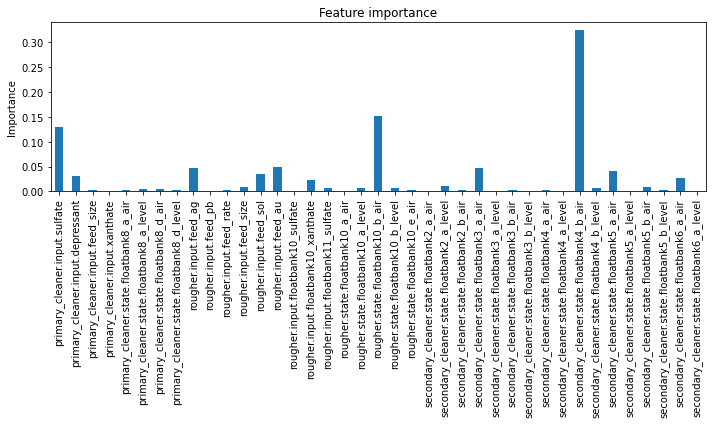

In [37]:
# посмотрим на признаки, наиболее сильно влияющие на целевые метрики
imp = pd.Series(model_y1.feature_importances_,
               X_train.columns)

fig, ax = plt.subplots(figsize=(10,6))
imp.plot.bar(ax=ax)
ax.set_title('Feature importance')
ax.set_ylabel('Importance')
fig.tight_layout()

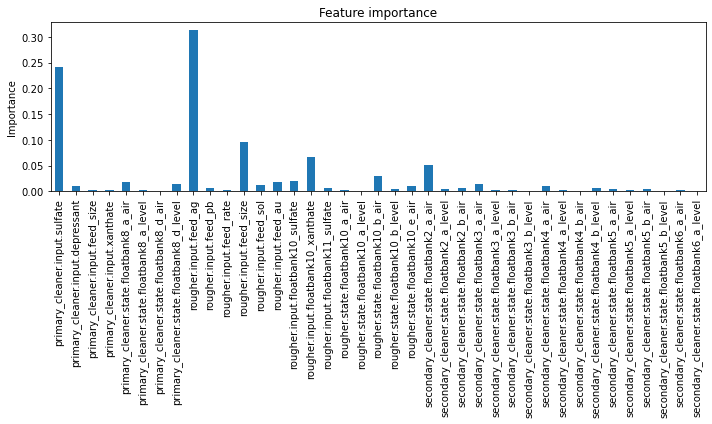

In [38]:
imp = pd.Series(model_y2.feature_importances_,
               X_train.columns)

fig, ax = plt.subplots(figsize=(10,6))
imp.plot.bar(ax=ax)
ax.set_title('Feature importance')
ax.set_ylabel('Importance')
fig.tight_layout()

Для разных целевых признаков свои признаки, наиболее сильно влияющие на предсказание. 

Для предсказания эффективности обогащения чернового концентрата наибольшее влияние оказывают показание кислорода на некоторых флотационных установках на этапе вторичной очистки, а также количество реагента (sulfate) на стадии первичной очистки.

Для предсказания эффективности обогащения финального концентрата наибольшее влияние оказывают начальное содержание серебра в сырье и количество реагента (sulfate) на стадии первичной очистки. 

 В ходе решения задачи проекта подготовлен прототип модели машинного обучения, способная предсказать коэффициент восстановления золота из золотосодержащей руды.

Обучена модель Случайный лес с подобранными оптимальными гиперпараметрами и получен лучший показатель метрики sMAPE.

Кроме того, выполнены следующие этапы и получены соотвествующие результаты:
1. Данные подготовлены:
   - эффективность обогащения rougher.output.recovery расчитана правильно (mae = 0);
   - Из тренировочной выборки удалены признаки, недоступные в тестовой;
   - Устранена мультиколлинеарность признаков;
   - Проведена предобработка данных.
2. Данные проанализированы:
   -  Оценено распределение концентрации металлов (Au, Ag, Pb) на различных этапах очистки:
      - Концентрация серебра уменьшается по мере очистки;
      - Концентрация золота увеличивается по мере очистки;
      - Концентраия свинца остается практически неизменной после первичной и вторичной очистки.
   - Распределения размеров гранул сырья на обучающей и тестовой выборках имеют схожий характер;
   - После обогащения суммарная концентрация веществ увеличивается. 
3. Построена и оптимизирована модель машинного обучения:
   - лучшая модель - Случайный лес;
   - sMAPE на тестовых данных меньше, чем ддя константной модели.